# **1. Installing Libraries**

In [8]:
# Install necessary libraries for Machine Learning and data processing
# `scikit-learn`: For ML model building, data preprocessing, and evaluation
# `xgboost`: A powerful gradient boosting algorithm used for classification
# `category_encoders`: For encoding categorical variables (Target Encoding)
!pip install scikit-learn --upgrade xgboost category_encoders

# **2. Importing Libraries**

In [9]:
# Import necessary libraries for data manipulation, model building, and evaluation
import pandas as pd  # For data handling and manipulation
import numpy as np  # For numerical operations
from xgboost import XGBClassifier  # XGBoost classifier for building the fraud detection model
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For data scaling and encoding categorical variables
from category_encoders import TargetEncoder  # For Target Encoding high-cardinality categorical features
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, matthews_corrcoef  # Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report  # For model evaluation
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.compose import ColumnTransformer  # For building preprocessing pipelines
from sklearn.pipeline import Pipeline  # To chain multiple processing steps together
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.feature_selection import mutual_info_classif  # Mutual Information for feature selection
from sklearn.metrics import recall_score  # For calculating the recall, which measures the model's ability to identify positive cases (fraud).
import joblib  # For saving and loading trained models


# **3. Loading the Dataset**

In [10]:
# Load the dataset into a DataFrame (table of data)
# pd.read_csv is used to read a CSV file
df = pd.read_csv('fraudTrain.csv')

# Display the first few rows of the dataset to get an overview
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# **4. Date and Time Feature Engineering**

In [11]:
# Convert the transaction date to a datetime format so we can extract useful features from it
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Create new columns based on the date (transaction hour, day of the week, and month)
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['transaction_dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
df['transaction_month'] = df['trans_date_trans_time'].dt.month

# Convert the 'dob' (date of birth) column into a datetime format for further feature extraction
df['dob'] = pd.to_datetime(df['dob'])

# Extract year, month, and day of birth to create additional features
df['birth_year'] = df['dob'].dt.year
df['birth_month'] = df['dob'].dt.month
df['birth_day'] = df['dob'].dt.day

# Drop columns that are irrelevant to the model (e.g., name, credit card number, street)
df = df.drop(['Unnamed: 0', 'trans_date_trans_time','first','last','street', 'cc_num', 'city', 'unix_time', "state",'job', 'dob', 'trans_num'], axis=1)


# **5. Handling Imbalanced Dataset**

In [12]:
# Split the data into features (X) and target (y)
# 'X' includes all the columns except 'is_fraud', which is the label we want to predict
# 'y' is the target variable, 'is_fraud', which is 1 if the transaction is fraudulent, and 0 otherwise
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data into training (80%) and testing (20%) sets
# The model will be trained on the training set and evaluated on the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Since fraudulent transactions are rare (imbalanced data), we give more weight to fraud cases
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# **6. Building the XGBoost Classifier**

In [13]:
# Initialize the XGBoost classifier with the class weights for handling the imbalance
# scale_pos_weight helps balance the impact of fraud (rare) and non-fraud (common) transactions
clf = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')

# **7. Handling Categorical Features**

In [14]:
# Some features are categorical (e.g., merchant, category, gender), and need to be encoded numerically for the model

# Specify the categorical columns to be encoded
cat_columns = ['merchant', 'category', 'gender']

# One-Hot Encoding for low-cardinality features (e.g., gender, category)
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Target Encoding for high-cardinality features (e.g., merchant)
# This replaces merchant names with the average fraud rate for each merchant
te = TargetEncoder(handle_missing='value')
te.fit(X_train['merchant'], y_train)

# Define numerical columns, excluding 'first' column
num_columns = X.select_dtypes(include=np.number).columns.tolist()

# Check and remove 'first' and 'last' from num_columns if present
if 'first' in num_columns:
    num_columns.remove('first')  # Remove 'first' from numerical features
if 'last' in num_columns:
    num_columns.remove('last')  # Remove 'last' from numerical features

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_columns),
    ('ohe', ohe, ['gender', 'category']),  # One-Hot Encoding
    ('te', te, ['merchant'])               # Target Encoding
], remainder='passthrough') # Passthrough for any remaining columns

# **8. Preprocessing Pipeline**


In [15]:
# Create a pipeline that scales numerical features, applies One-Hot and Target Encoding, and trains the classifier

# ColumnTransformer: Applies different transformations to different columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_columns),  # Standardize numerical features
    ('ohe', ohe, ['gender', 'category']),   # One-Hot Encoding for gender and category
    ('te', te, ['merchant'])                # Target Encoding for merchant
], remainder='passthrough')


# Combine preprocessing and model training into a single pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', clf)  # The XGBoost classifier is the final step
])

# Fit the preprocessor on training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_train_transformed
# Transform the test data
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed

X_train
y_train
# Fit/Train the model to the training data
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:41:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['amt', 'zip', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long',
                                                   'transaction_hour',
                                                   'transaction_dayofweek',
                                                   'transaction_month',
                                                   'birth_year', 'birth_month',
                                                   'birth_day']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['gender', 'catego...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# **9. Evaluating & Saving the Model**

In [20]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of fraud

# Evaluate the model using various metrics
# AUC-ROC: Measures how well the model separates fraud from non-fraud
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

# F1 Score: Harmonic mean of precision and recall (useful for imbalanced data)
print("F1 Score:", f1_score(y_test, y_pred))

# MCC: Accounts for true/false positives and negatives, useful for imbalanced datasets
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

# Recall: Calculates and prints recall, indicating the model's ability to identify positive cases.
print("Recall:", recall_score(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report: Generates and prints a detailed classification report, summarizing precision, recall, and F1-score for each class.
print("Classification Report", classification_report(y_test, y_pred))


AUC-ROC: 0.9979537576413932
F1 Score: 0.6458519179304193
Matthews Correlation Coefficient: 0.6798894300485359
Recall: 0.9526315789473684
Accuracy: 0.9938766460369792
Classification Report               precision    recall  f1-score   support

           0       1.00      0.99      1.00    257815
           1       0.49      0.95      0.65      1520

    accuracy                           0.99    259335
   macro avg       0.74      0.97      0.82    259335
weighted avg       1.00      0.99      0.99    259335



In [21]:
# Save the trained pipeline model
joblib.dump(pipeline, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']

# **10. Precision-Recall Curve**

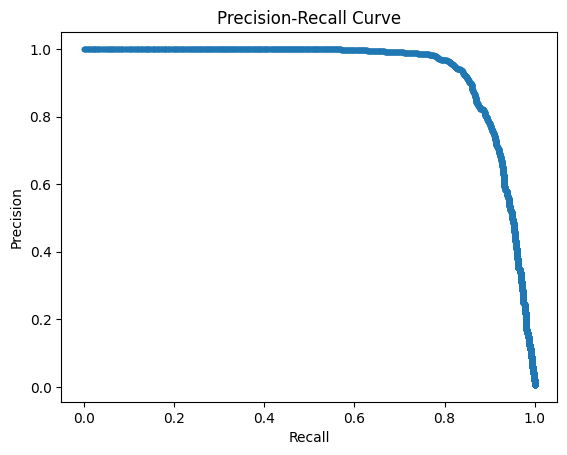

In [11]:
# Plot the Precision-Recall curve
# Helps visualize the trade-off between precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# **11. Feature Importance**


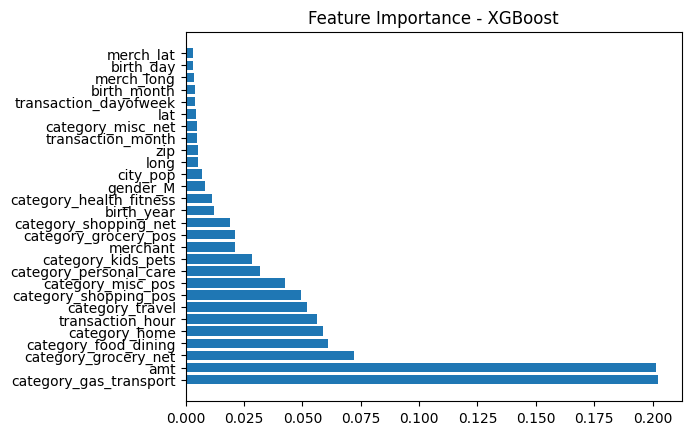

In [12]:
# Plot the feature importance as determined by the XGBoost model
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# List the feature names after encoding
feature_names = num_columns + list(preprocessor.named_transformers_['ohe'].get_feature_names_out(['gender', 'category'])) + ['merchant']

# Include 'first' and 'last' in the feature names if they were present initially
feature_names = num_columns + list(preprocessor.named_transformers_['ohe'].get_feature_names_out(['gender', 'category'])) + ['merchant']
if 'first' in X.columns:
    feature_names.append('first')  # Add 'first' if present
if 'last' in X.columns:
    feature_names.append('last')  # Add 'last' if present

# Plot a horizontal bar graph of feature importance
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.title('Feature Importance - XGBoost')
plt.show()

# **12. Recursive Feature Elimination**

In [13]:
# Recursive Feature Elimination (RFE)
# Transform X_train using the preprocessor before applying RFE
X_train_transformed_rfe = preprocessor.transform(X_train)  # Transform data for RFE
rfe = RFE(estimator=clf, n_features_to_select=10)  # Create RFE object to select 10 features
rfe.fit(X_train_transformed_rfe, y_train)  # Fit RFE using transformed training data
print("Selected features by RFE:", np.array(feature_names)[rfe.support_])  # Print selected feature names

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Selected features by RFE: ['amt' 'transaction_hour' 'category_food_dining' 'category_gas_transport'
 'category_grocery_net' 'category_grocery_pos' 'category_home'
 'category_kids_pets' 'category_misc_pos' 'category_travel']


# **13. Dimensionality Reduction using PCA**

In [14]:
# Principal Component Analysis (PCA) reduces the number of features while preserving most of the variance

# Preprocessing pipeline for PCA (separate from the main pipeline)
pca_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_columns),  # Standardize numerical features
    ('ohe', ohe, ['gender', 'category']),  # One-Hot Encoding for gender and category
    ('te', te, ['merchant'])  # Target Encoding for merchant
], remainder='drop')  # Drop any remaining columns

# We preprocess the data before applying PCA
X_train_pca_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_pca_transformed = preprocessor.transform(X_test)

# Apply PCA, reducing to 2 components for simplicity
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_pca_transformed)
X_test_pca = pca.transform(X_test_pca_transformed)

# Train the model on the PCA-transformed data
clf_pca = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
clf_pca.fit(X_train_pca, y_train)

# Evaluate after PCA
y_pred_pca = clf_pca.predict(X_test_pca)
print("F1 Score after PCA:", f1_score(y_test, y_pred_pca))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

# **14. Mutual Information for Feature Selection**


In [ ]:
# Apply preprocessing to X_train for mutual information calculation
X_train_mi = preprocessor.transform(X_train) # Transform training data for MI calculation

# Mutual Information
mi = mutual_info_classif(X_train_mi, y_train)  # Calculate mutual information using the transformed data
mi = pd.Series(mi, index=feature_names)  # Create a Series to using feature_names for better indexing
mi.sort_values(ascending=False).plot.bar(figsize=(12, 6))  # Plot MI values
plt.title('Mutual Information for Feature Selection')  # Title for the plot
plt.show()  # Display the plot
